In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import os
%matplotlib inline

In [2]:
class DataImputer:
    def train_test_pred_split(self, trimmed_data, train_data, input_columns, output_column='Power'):
        X_pred = trimmed_data.loc[:, input_columns].values
        X = train_data.loc[:, input_columns].values
        Y = train_data[output_column].values
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
        return X_train, X_test, Y_train, Y_test, X_pred

    def trim_data(self, data, input_columns, output_column='Power', predicted_column='PredictedPower'):
        trimmed_data = data.dropna(subset=input_columns)
        train_data = trimmed_data.dropna(subset=input_columns+[output_column])
        trimmed_data = trimmed_data[trimmed_data[predicted_column].isna()]
        return trimmed_data, train_data

    def predict(self, X_train, X_test, Y_train, Y_test, X_pred):
        alg = LinearRegression()
        alg.fit(X_train, Y_train)
        if X_test is not None and Y_test is not None:
            score = alg.score(X_test, Y_test)
        else:
            score = alg.score(X_test, Y_test)
        Y_pred = alg.predict(X_pred)
        return Y_pred, score

    def fill_values(self, data, time_instants, values, predicted_column='PredictedPower'):
        count = 0
        if len(time_instants)!=len(values):
            print("Length mismatch for filling values")
            return None
        for time, value in zip(time_instants, values):
            data.loc[time, predicted_column] = value
            count+=1
        return data, count

class IITG_DataLoader:
    data = None

    __power_key = 'Power'

    def __init__(self, data = None):
        self.functions = Functions()
        if data is not None:
            self.data = data
        
    def __update_corrupt_power(self, row):
        # if (not type(row[self.__power_key])==str) and row[self.__power_key] > 10:
        #     return 'NR'
        if (type(row[self.__power_key])==str) and ',' in row[self.__power_key]:
            return float(row[self.__power_key].replace(',', '.'))
        else:
            return row[self.__power_key]
        
        
    def preprocess(self, data = None, interpolate = False, update=False):
        if data is None:
            if self.data is None:
                print("Data not found in method: preprocess")
                return None
            data = self.data.copy()
        # Preprocess Time Column
        data.index = pd.to_datetime(data.index)

        # Preprocess Power Column
        data[self.__power_key] = data.apply(self.__update_corrupt_power, axis=1)
        data[self.__power_key] = pd.to_numeric(data[self.__power_key], errors='coerce')

        # Sort data by Time
        
        data = data.sort_index()

        if interpolate:
            data = self.functions.interpolate(data)
            data = self.functions.interpolate(data, method='bfill')
            data = self.functions.interpolate(data, method='ffill')
        if update:
            self.data = data
        return data
    
    def set_time_as_index(self, data, time_header='Time'):
        data = data.drop_duplicates(subset=[time_header])
        data = data.set_index(time_header, drop=True)
        data.index.name = None
        return data
        
    def load(self, file_list, interpolate = False, time_header='Time', power_header='Power'):
        data = pd.DataFrame()
        for file_path in file_list:
            target_columns = [time_header, power_header]
            header_row = None
            
            df = pd.read_excel(file_path, header=None)
            for i, row in enumerate(df.values):
                row_lower = [str(cell).lower() for cell in row]  
                if all(col_name.lower() in row_lower for col_name in target_columns):
                    header_row = i
                    break  

            if header_row is not None:
                df.columns = df.iloc[header_row]
                df = df.iloc[header_row+1:][target_columns]
                data = pd.concat([data, df], ignore_index=True)
            else:
                print("Header row not found in the file:", file_path)
        data = self.set_time_as_index(data, time_header)
        data.rename(columns = {power_header:self.__power_key}, inplace=True)
        data = self.preprocess(data, interpolate)
        self.data = data
        return data
    
    def load_all(self, folder_path, interpolate = False, time_header='Time', power_header='Power',\
                 start_time=None, end_time=None):
        file_list = []
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    file_list.append(file_path)
        data = self.load(file_list, interpolate, time_header, power_header)
        if start_time is not None and end_time is not None:
            data = self.get_data(start_time, end_time, data)
            self.set_data(data)
        return data
    
    def get_data(self, start_time = None, end_time = None, data = None, use_month_key = False):
        if data is None:
            if self.data is None:
                print("Data not found in method: get_data")
                return None
            data = self.data.copy()
        if start_time is None and end_time is None:
            return data
        start_time = pd.to_datetime(start_time)
        end_time = pd.to_datetime(end_time)
        if use_month_key == True:
            mask = (data.index >= start_time) & (data.index <= end_time)
        else:
            mask = (data.index > start_time) & (data.index < end_time)
        data = data.loc[mask]
        return data
    
    def set_data(self, data):
        if data is not None:
            self.data = data
    
    def plot(self, start_time = None, end_time = None, data = None, type='plot', color='b'):
        if data is None:
            if self.data is None:
                print("Data not found in method: plot")
                return None
            data = self.data.copy()
        data = self.get_data(start_time, end_time, data)
        fig, ax1 = plt.subplots(figsize=(10, 6))
        # x = data[self.__time_key].values
        y = data[self.__power_key].values
        ax1.set_xlabel('Time', color='b')
        ax1.set_ylabel('Power Consumed', color='b')
        # fig=plt.figure()
        if type=='plot':
            plt.plot(y, color=color)
        elif type=='scatter':
            plt.scatter(y, color=color)
        fig.autofmt_xdate()
        # plt.show()
        return plt

    def describe(self, start_time = None, end_time = None, data = None):
        if data is None:
            if self.data is None:
                print("Data not found in method: describe")
                return None
            data = self.data.copy()
        
        data = self.get_data(start_time, end_time, data)
        shape = data.shape
        if start_time is None:
            start_time = pd.to_datetime(data.index[0])
        if end_time is None:
            end_time = pd.to_datetime(data.index[shape[0]-1])
        columns = ', '.join(data.columns)
        mean_power = data[self.__power_key].mean()
        nan_power = data[self.__power_key].isna().sum()
        table = {'Params': ['Columns', 'Shape', 'Start Time', 'End Time', 'Mean Power', 'NaN Powers'],
                'Values': [columns, shape, start_time, end_time, mean_power, nan_power]}
        return pd.DataFrame(table)
    
    def energy_consumed(self, start_time = None, end_time = None, data = None, use_monthly_data = False):
        if use_monthly_data == True:
            if data is None:
                if self.monthly_energy_data is None:
                    print("Data not found in method: energy_consumed")
                    return None
                data = self.monthly_energy_data
            data = self.get_data(start_time, end_time, data, use_month_key = True)
            return data[self.__energy_key].sum()
        if data is None:
            if self.data is None:
                print("Data not found in method: energy_consumed")
                return None
            data = self.data.copy()
        data = self.get_data(start_time, end_time, data)
        sample_points = data.index.diff().dt.total_seconds().fillna(0).cumsum().values
        mw = data[self.__power_key].values

        # Calculate the trapezoidal integration of 'MW' with respect to 'Time'
        integral = np.trapz(mw, x=sample_points) / 3600
        return integral

class Functions: 
    def interpolate(self, data = None, method='linear', column='Power'):
        if data is None:
                print("Data not found in method: interpolate")
        if isinstance(data, pd.DataFrame):
            series = data[column]
        elif isinstance(data, np.ndarray):
             series = data
        else:
            print("No supported type found. Please use either a dataframe or a series to interpolate.")
            return None
        if method=='bfill':
            series = series.bfill()
        elif method=='ffill':
            series = series.ffill()
        else:
            series = series.interpolate(method=method)
        if isinstance(data, pd.DataFrame):
            data[column] = series
        return data
    
    def find_trend(self, series, order):
        coef = np.polyfit(np.arange(len(series)), series.values.ravel(), order)
        poly_mdl = np.poly1d(coef)
        trend = pd.Series(data=poly_mdl(np.arange(len(series))))
        return trend

    def detrend_data(self, data, order, column='Power'):
        interpolated_data = self.interpolate(data.copy(), method='cubic', column=column)
        interpolated_data = self.interpolate(interpolated_data, method='bfill', column=column)
        interpolated_data = self.interpolate(interpolated_data, method='ffill', column=column)
        trend = self.find_trend(interpolated_data[column], order)
        detrended = data[column].values - trend
        detrended_data = data.copy()
        detrended_data[column] = detrended.values
        detrended_data.index = data.index
        return trend, detrended_data
    
    def time_to_column(self, time):
        word = 'Power(t'
        if time>0:
            word = word+'+'+str(time)+')'
        else:
            word = word+str(time)+')'
        return word
    
    def time_set_to_columns(self, times):
        columns = []
        for time in times:
            if isinstance(time, str):
                columns.append(time)
                continue
            column = self.time_to_column(time)
            columns.append(column)
        return columns
    
    def do_power_shifts(self, data, values, column='Power'):
        for val in values:
            new_column = self.time_to_column(val)
            data[new_column] = data[column].shift(val*(-1))
        return data
    
    def findSubs(self, arr, index, subs, allsubs): 
        if index == len(arr): 
            if len(subs) >= 1: 
                allsubs.append(subs)
        else: 
            self.findSubs(arr, index + 1, subs, allsubs) 
            self.findSubs(arr, index + 1, subs+[arr[index]], allsubs)

    def generate_combinations(self, daily, seasonal):
        daily_subs = []
        seasonal_subs = []

        self.findSubs(daily, 0, [], daily_subs)
        self.findSubs(seasonal, 0, [], seasonal_subs)

        all_subs = []
        for daily_sub in daily_subs:
            for seasonal_sub in seasonal_subs:
                l = daily_sub+seasonal_sub
                all_subs.append(l)
        return all_subs

In [3]:
functions = Functions()
imputer = DataImputer()

In [4]:
# Load power import data
folder_path = 'power_import_data/'
apdcl_import = IITG_DataLoader()
raw_import_data = apdcl_import.load_all(folder_path, interpolate=False, power_header='MW', \
                                        start_time='2022-02-02', end_time='2022-12-31')
raw_import_data.loc[raw_import_data['Power'] > 10, 'Power'] = None

In [5]:
# Load pv generation (phase 2) data
folder_path = 'pv_gen_data/'
pv_gen = IITG_DataLoader()
solar_data = pv_gen.load_all(folder_path, interpolate=False, time_header='x1', power_header='ActivePower',\
                 start_time='2022-02-02', end_time='2022-12-31')
# Divide solar power values by 1000 to convert it from kWh to MWh
solar_data = solar_data[solar_data['Power'] > 0]
solar_data.loc[:,'Power'] = solar_data['Power']/1000

In [6]:
folder_path = 'weather_data/'
weather = IITG_DataLoader()
weather_data = weather.load_all(folder_path, interpolate=False, power_header='Temperature')

In [7]:
weather_data.rename(columns={'Power':'Temperature'}, inplace=True)
weather_data.head()

,Temperature
2022-01-01 00:00:00,15.00
2022-01-01 03:30:00,12.78
2022-01-01 04:00:00,12.78
2022-01-01 04:30:00,12.22
2022-01-01 05:00:00,12.22


In [8]:
# Compute total demand data
# Total Demand = Power Import + 1.9 * PV Generation (Phase 2)
demand_data = pd.merge(raw_import_data, solar_data, suffixes=('_import', '_solar'), \
                     left_index=True, right_index=True, how='left')
demand_data['Power_solar'].fillna(0, inplace=True)
demand_data['Power'] = demand_data['Power_import'] + 1.9*demand_data['Power_solar']
demand_data = demand_data.drop(columns=['Power_import','Power_solar'])
demand_data.head()

,Power
2022-02-02 01:00:00,NaN
2022-02-02 02:00:00,NaN
2022-02-02 03:00:00,NaN
2022-02-02 04:00:00,NaN
2022-02-02 05:00:00,2.3


In [9]:
demand_data = pd.merge(demand_data, weather_data, \
                     left_index=True, right_index=True, how='left')
demand_data.head()

,Power,Temperature
2022-02-02 01:00:00,NaN,NaN
2022-02-02 02:00:00,NaN,NaN
2022-02-02 03:00:00,NaN,NaN
2022-02-02 04:00:00,NaN,13.89
2022-02-02 05:00:00,2.3,13.89


In [34]:
demand_data

,Power,Temperature
2022-02-02 01:00:00,NaN,NaN
2022-02-02 02:00:00,NaN,NaN
2022-02-02 03:00:00,NaN,NaN
2022-02-02 04:00:00,NaN,13.89
2022-02-02 05:00:00,2.3,13.89
...,...,...
2022-12-30 19:00:00,2.7,16.11
2022-12-30 20:00:00,NaN,15.00
2022-12-30 21:00:00,2.7,13.89
2022-12-30 22:00:00,3.0,13.89


In [98]:
# Detrend the data 
trend_power, detrended_demand_data = functions.detrend_data(demand_data, order=15, column='Power')
trend_temperature, detrended_demand_data = functions.detrend_data(detrended_demand_data, order=15, column='Temperature')
# detrended_demand_data = demand_data.copy()
detrended_demand_data.head(10)

,Power,Temperature
2022-02-02 01:00:00,NaN,NaN
2022-02-02 02:00:00,NaN,NaN
2022-02-02 03:00:00,NaN,NaN
2022-02-02 04:00:00,NaN,-0.784529
2022-02-02 05:00:00,-0.010679,-0.802719
2022-02-02 06:00:00,-0.308441,-0.820920
2022-02-02 07:00:00,-0.243140,-0.839129
2022-02-02 08:00:00,0.744761,-0.857345
2022-02-02 09:00:00,0.922123,1.344435
2022-02-02 10:00:00,0.945061,2.436211


In [99]:
detrended_demand_data['abs_Temperature'] = abs(detrended_demand_data['Temperature'])
detrended_demand_data.head(10)

,Power,Temperature,abs_Temperature
2022-02-02 01:00:00,NaN,NaN,NaN
2022-02-02 02:00:00,NaN,NaN,NaN
2022-02-02 03:00:00,NaN,NaN,NaN
2022-02-02 04:00:00,NaN,-0.784529,0.784529
2022-02-02 05:00:00,-0.010679,-0.802719,0.802719
2022-02-02 06:00:00,-0.308441,-0.820920,0.820920
2022-02-02 07:00:00,-0.243140,-0.839129,0.839129
2022-02-02 08:00:00,0.744761,-0.857345,0.857345
2022-02-02 09:00:00,0.922123,1.344435,1.344435
2022-02-02 10:00:00,0.945061,2.436211,2.436211


In [100]:
detrended_demand_data['Temperature_2'] = detrended_demand_data['Temperature']*detrended_demand_data['abs_Temperature']
detrended_demand_data.drop(columns=['abs_Temperature'], inplace=True)
detrended_demand_data.head(10)

,Power,Temperature,Temperature_2
2022-02-02 01:00:00,NaN,NaN,NaN
2022-02-02 02:00:00,NaN,NaN,NaN
2022-02-02 03:00:00,NaN,NaN,NaN
2022-02-02 04:00:00,NaN,-0.784529,-0.615486
2022-02-02 05:00:00,-0.010679,-0.802719,-0.644358
2022-02-02 06:00:00,-0.308441,-0.820920,-0.673909
2022-02-02 07:00:00,-0.243140,-0.839129,-0.704137
2022-02-02 08:00:00,0.744761,-0.857345,-0.735040
2022-02-02 09:00:00,0.922123,1.344435,1.807505
2022-02-02 10:00:00,0.945061,2.436211,5.935125


In [101]:
detrended_demand_data

,Power,Temperature,Temperature_2
2022-02-02 01:00:00,NaN,NaN,NaN
2022-02-02 02:00:00,NaN,NaN,NaN
2022-02-02 03:00:00,NaN,NaN,NaN
2022-02-02 04:00:00,NaN,-0.784529,-0.615486
2022-02-02 05:00:00,-0.010679,-0.802719,-0.644358
...,...,...,...
2022-12-30 19:00:00,0.233549,1.097361,1.204201
2022-12-30 20:00:00,NaN,0.040305,0.001625
2022-12-30 21:00:00,0.228929,-1.016237,-1.032738
2022-12-30 22:00:00,0.526513,-0.962257,-0.925939


In [102]:
import copy
# Function for imputing the data
def impute(data, daily, periodic):
    results = []

    # Generate all combinations for columns with the daily and periodic values
    time_sets = functions.generate_combinations(daily, periodic)
    time_sets = copy.deepcopy(time_sets)+copy.deepcopy(time_sets)+copy.deepcopy(time_sets)
    for i in range(len(time_sets)//2):
        time_sets[i].append('Temperature')
        time_sets[i].append('Temperature_2')
    # print(time_sets)

    # Loop through each combination and compute its predictions and score 
    for time_set in time_sets:
        if len(time_set)==0:
            continue
        input_columns = functions.time_set_to_columns(time_set)
        # print(input_columns)

        trimmed_data, train_data = imputer.trim_data(data, input_columns)
        X_train, X_test, Y_train, Y_test, X_pred = imputer.train_test_pred_split(trimmed_data, train_data, input_columns)
        if X_train.shape[0]<1000 or X_pred.shape[0]<1:
            continue
        Y_pred, score = imputer.predict(X_train, X_test, Y_train, Y_test, X_pred)

        time_instants = trimmed_data.index
        if(score>0.85):
            results.append((score, time_instants, Y_pred, input_columns))
        
    # Sort the results wrt scores
    # sorted(results, key=lambda x: x[0], reverse=True)
    results.sort()
    results.reverse()
    filled = 0
    # print(results)
    # Fill the values. Values with higher score's model are filled first.
    for result in results:
        # print(result[0], result[3])
        data, count = imputer.fill_values(data, result[1], result[2])
        filled+=count 
    return filled

In [103]:
# Define daily and periodic time instants
daily = [1,-1,2,-2]
periodic = [24,-24,48,-48]
detrended_demand_data['PredictedPower'] = [np.nan]*detrended_demand_data.shape[0]
while detrended_demand_data['Power'].isna().sum()>10:
    functions.do_power_shifts(detrended_demand_data, daily+periodic)
    impute(detrended_demand_data, daily, periodic)
    detrended_demand_data['Power'] = detrended_demand_data['PredictedPower']

In [104]:
detrended_demand_data['PredictedPower'].isna().sum()

4

In [105]:
# Get the final values by adding trend to the predicted data
predicted_values = detrended_demand_data['PredictedPower'].values+trend_power
predicted_data = pd.DataFrame({'Power':demand_data['Power'].values, 'PredictedPower':predicted_values})
predicted_data.index = detrended_demand_data.index

[]

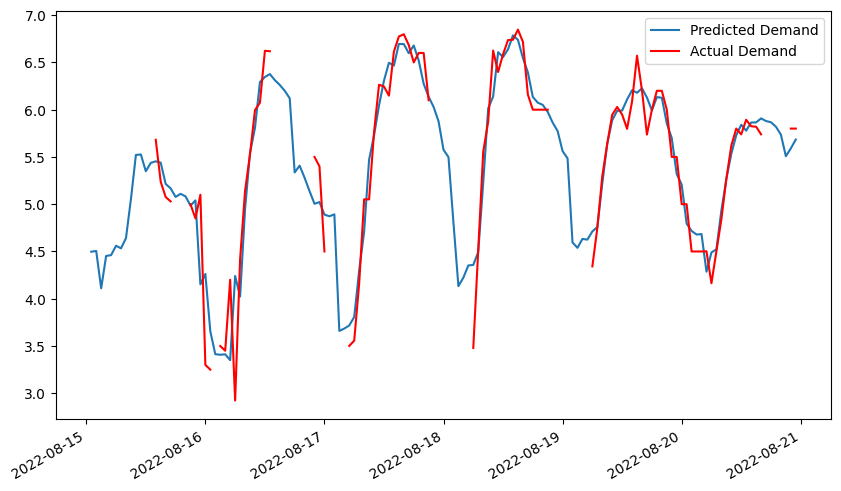

In [112]:
# Visualize the data
start_time_ana = pd.to_datetime('2022-08-15')
end_time_ana = pd.to_datetime('2022-08-21')

filtered_data = predicted_data[(predicted_data.index>start_time_ana) & (predicted_data.index<end_time_ana)]

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.plot(filtered_data.index, filtered_data['PredictedPower'])
plt.plot(filtered_data.index, filtered_data['Power'], color='red')
fig.autofmt_xdate()
plt.legend(['Predicted Demand', 'Actual Demand'])
plt.plot()

In [107]:
# Score of the predicted values wrt actual
df = predicted_data.dropna(subset=['Power', 'PredictedPower'])
r2 = r2_score(df['Power'], df['PredictedPower'])
print("R-squared Score:", r2)

R-squared Score: 0.9349450842706908
